In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from IPython.display import display
import sys
import pandas as pd
import seaborn.apionly as sns
plt.style.use('ggplot')
sns.set_style('ticks')
import re
import matplotlib.ticker as ticker
# import mdsynthesis as mds
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
# Enable inline plotting  
%matplotlib inline

/Users/oliver/anaconda3/envs/mda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/

In [2]:
print ('Python version ' + sys.version)
print ('Pandas version ' + pd.__version__)
print ('Numpy version ' + np.__version__)

Python version 3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.24.2
Numpy version 1.16.4


# Output from Production Run  

In [3]:
# Data1 represents the time per rank per repeat for each component inside the RMSD function
data1='data-comm-updated-rmsd-parallel-IO-Comet/data1.txt'
# Data2 represents the timing of the different sections of the code per rank per repeat for each run 
data2='data-comm-updated-rmsd-parallel-IO-Comet/data2.txt'

# Load Data

In [4]:
# Load overal timing into a dataframe called df1 (use data1.txt)
df1 = pd.read_csv(data1, delimiter=' ', header=None, names=['blocks', 'repeat', 'P_ID', 't_comp', 't_IO', 't_IO_plus_t_comp',
                                                            't_end_loop', 't_init'])
                                                            # t_init is t_opening_trajectory in the paper
df1_copy = df1.copy()
df1_orig = df1.copy() 

outlier is blocks==288, repeat==1

In [5]:
OUTLIER = {'blocks': 288, 'repeat': 1}

In [6]:
outliers1 = (df1_orig[['blocks', 'repeat']] == (OUTLIER['blocks'], OUTLIER['repeat'])).all(axis=1)
print("Outliers data contains", sum(outliers1), "observations")

Outliers data contains 288 observations


In this notebook: remove the outlier

In [7]:
print("Original data", len(df1))
df1 = df1_orig[~outliers1]
df1_copy = df1.copy()    # df1_copy is used later :-p ...
print("Cleaned data",len(df1))

Original data 8765
Cleaned data 8477


In [8]:
df1 = pd.concat([df1.groupby('blocks', as_index=False).mean(), df1.groupby('blocks', as_index=False).max().loc[:,'t_IO_plus_t_comp'], 
                 df1.groupby('blocks', as_index=False).std().loc[:,['t_comp','t_IO']]],axis=1)

In [9]:
df1.columns = ['blocks', 'repeat', 'P_ID', 't_comp', 't_IO', 't_IO_plus_t_comp_mean','t_end_loop', 't_init', 
               't_IO_plus_t_comp_max','std_comp','std_IO']

outlier data

In [10]:
df1_outlier = df1_orig[outliers1]
df1_copy_outlier = df1_outlier.copy()
df1_outlier = pd.concat([df1_outlier.groupby('blocks', as_index=False).mean(), df1_outlier.groupby('blocks', as_index=False).max().loc[:,'t_IO_plus_t_comp'], 
                 df1_outlier.groupby('blocks', as_index=False).std().loc[:,['t_comp','t_IO']]],axis=1)
df1_outlier.columns = ['blocks', 'repeat', 'P_ID', 't_comp', 't_IO', 't_IO_plus_t_comp_mean','t_end_loop', 't_init', 
               't_IO_plus_t_comp_max','std_comp','std_IO']

In [11]:
df1_outlier

,blocks,repeat,P_ID,t_comp,t_IO,t_IO_plus_t_comp_mean,t_end_loop,t_init,t_IO_plus_t_comp_max,std_comp,std_IO
0,288,1.0,143.5,0.800807,10.0918,10.905271,9.122822e-07,0.00011,18.457859,0.027472,4.676686


# Data 2 Preparation 

In [12]:
with open(data2, 'r') as f:
    l = f.readlines()

In [13]:
def Flatten(TheList):
    a = str(TheList)
    b,crap = re.subn(r'(\]|\[)', '\n', a)
    c = b.split('\n')

    return(c)

def Flatten1(TheList):
    a = TheList
    b,crap = re.subn(r',', '', a)

    return(b)

In [14]:
## Some modification to the input format to convert it to the desired format

l1 = []
for l_i in l:
    d = Flatten(l_i)
    b = []
    for lng in range(len(d)):
        if(len(d[lng])>1):b.append(d[lng])      
       
    b1 = Flatten1(b[1])   
    b1 = list(map(float, b1.split()))
    a1 = b[0].split(' ')
    a1.remove('')
    a1 = list(map(int, a1))
    l1.append((a1 + b1))

# Data Post-Processing 

Written by
```python
 with open('data2.txt', mode='a') as file2:
        file2.write("{} {} {}\n".format(size, j, tot_time))
        file2.write("{} {} {}\n".format(size, j, init_time))
        file2.write("{} {} {}\n".format(size, j, comm_time1)) 
        file2.write("{} {} {}\n".format(size, j, comm_time2))
        file2.write("{} {} {}\n".format(size, j, comm_time3))
        file2.write("{} {} {}\n".format(size, j, comp_time))	
        file2.write("{} {} {}\n".format(size, j, access_time))
```
i.e. 7 rows per run (indexed by `size` and `j`).

In [15]:
# Load timing per N_p per repeat into a dataframe called df2 (use data2.txt)
df2 = pd.DataFrame(l1, index=None, columns=None)
df2.shape

(595, 386)

In [16]:
outliers2 = (df2.iloc[:, 0:2] == (OUTLIER['blocks'], OUTLIER['repeat'])).all(axis=1)

In [17]:
df2_outlier = df2[outliers2]
df2_outlier

,0,1,2,3,4,5,6,7,8,9,...,376,377,378,379,380,381,382,383,384,385
525,288,1,2.369442,2.330493,2.323528,2.320353,2.275919,2.300967,2.290210,2.315142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,288,1,93.953494,93.966494,93.916463,93.895280,93.911373,94.036756,93.843472,93.865459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527,288,1,0.000518,0.000592,0.000504,0.000502,0.000489,0.000479,0.000512,0.000499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528,288,1,0.041964,0.000397,0.001365,0.001440,0.001992,0.002021,0.002175,0.002199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
529,288,1,0.004787,0.000024,0.000162,0.000023,0.000326,0.000025,0.000134,0.000022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,288,1,2.327478,2.330097,2.322163,2.318912,2.273927,2.298946,2.288035,2.312943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,288,1,16.253955,16.252141,16.259311,16.262626,16.307468,16.282615,16.293415,16.268600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


remove outlier

In [18]:
df2 = df2[~outliers2]

In [19]:
df2.shape

(588, 386)

### big data analysis sausage maker
(reorganized into a big scary function)

In [20]:
def analyze_data(df1, df2, df1_copy):
    # df_t_total, df_comm, df_comp contains timing for all ranks across all repeats and all N_p
    ind = []                # Indices for Total number of ranks and repeat
    df_comm = []            # Communication time 
    df_comp = []            # Compute time
    df_t_total = []         # Total time for the task
    df_close = []
    for name, group in df2.groupby([0,1]):
        group.index = range(7)
        df_t_total.append(group.iloc[0,2:])
        ind.append(group.iloc[0,:1])
        df_comm.append(group.loc[3])
        df_comp.append(group.loc[5])
        df_close.append(group.loc[6])

    # Communication time averaged over all ranks for each run
    df_comm1 = pd.DataFrame(df_comm).loc[2:].groupby(0, as_index=False).mean()

    # Compute time averaged over all ranks for each run
    df_comp1 = pd.DataFrame(df_comp).loc[2:].groupby(0, as_index=False).mean()

    # Total time averaged over all repeats for each N_p
    df_t_tot1 = pd.concat([pd.DataFrame(ind, index=range(len(ind))), 
                           pd.DataFrame(df_t_total, index=range(len(ind)))], axis=1).loc[2:].groupby(0, as_index=False).mean() 

    # Total time for each repeat and each N_p
    df_t_tot_rank = pd.concat([pd.DataFrame(ind, index=range(len(ind))), pd.DataFrame(df_t_total, index=range(len(ind)))], axis=1)

    # Communication time for each repeat and each N_p
    df_comm_rank = pd.DataFrame(df_comm, index=range(len(ind)))

    # Compute time for each repeat and each N_p
    df_comp_rank = pd.DataFrame(df_comp, index=range(len(ind)))

    # Close time for each repeat and each N_p
    df_close_rank = pd.DataFrame(df_close, index=range(len(ind)))

    # Max value of each timing across all ranks per N_p per repeat 
    df_max_Np = df1_copy.groupby(['blocks','repeat'], as_index=False).max()

    # Max value of each timing across all ranks per N_p per repeat AVERAGED OVER REPEATS
    df_avg_repeat = df_max_Np.groupby('blocks', as_index=False).mean()

    df_std_repeat = df_max_Np.groupby('blocks', as_index=False).std().drop(['blocks','repeat','P_ID'],axis=1)
    df_std_repeat.columns = ['std_t_comp','std_t_IO','std_t_IO_plus_t_comp','std_t_end_loop','std_t_init']

    # Max value of communication across all ranks per N_p per repeat 
    df_comm_max_repeat = pd.concat([df_comm_rank.loc[:,:1],df_comm_rank.loc[:,2:].max(axis=1)],axis=1)
    df_comm_max_repeat.columns = [0,1,2]

    df_comm_max_avg_repeat = df_comm_max_repeat.groupby(0, as_index=False).mean()
    df_comm_max_std_repeat = df_comm_max_repeat.groupby(0, as_index=False).std()

    # Concat all timing into one single dataframe.
    df_avg_repeat = pd.concat([df_avg_repeat,df_comm_max_avg_repeat[2]],axis=1)
    df_avg_repeat.columns = [u'blocks', u'repeat', u'P_ID', u't_comp', u't_IO', u't_IO_plus_t_comp',
                             u't_end_loop', u't_init','Communication']

    # Calculate standard deviation for all timings in df_avg_repeat
    df_std_repeat = df_max_Np.groupby('blocks', as_index=False).std().drop(['blocks','repeat','P_ID'],axis=1)
    df_std_repeat = pd.concat([df_std_repeat,df_comm_max_std_repeat[2]],axis=1)
    df_std_repeat.columns = ['std_t_comp','std_t_IO','std_t_IO_plus_t_comp','std_t_end_loop','std_t_init','std_comm'] 

    # Concat timing values and calculated standard deviation into one dataframe.
    dff = pd.concat([df_avg_repeat,df_std_repeat],axis=1)

    # Compute time averaged over all ranks for each repeat and N_p
    df_comp2 = pd.DataFrame(df_comp, index=range(len(ind))).loc[:,2:].mean(axis=1)

    # Communication time averaged over all ranks for each repeat and N_p
    df_comm2 = pd.DataFrame(df_comm, index=range(len(ind))).loc[:,2:].mean(axis=1)

    # Max total time of all ranks for each repeat and N_p
    df_t_tot = pd.concat([pd.DataFrame(ind, index=range(len(ind)), dtype=int), pd.DataFrame(df_t_total, index=range(len(ind))).max(axis=1)], axis=1)

    df_t_tot.columns = ['size', 't_tot_max']

    # Combine df_comm2, df_comp2 into df_time
    df_time = pd.concat([pd.DataFrame(ind, index=range(len(ind)), dtype=int),df_comm2, df_comp2], axis=1)
    df_time.columns = ['size', 'Communication Time', 'RMSD time']

    a = pd.concat([df_t_tot, df_comm2, df_comp2], axis=1)

    df_time = df_time.groupby('size',as_index=False).mean()

    df_time['overhead'] = abs(df_time['RMSD time']-df1['t_IO_plus_t_comp_max'])

    df_t_tot_final = pd.concat([df_t_tot.groupby('size', as_index=False).mean(),df_t_tot.groupby('size', as_index=False).std().iloc[:,1]], axis=1)

    df_t_tot_final.columns = ['size', 't_tot_max', 'std_tot_max']

    df6 = pd.concat([df2.loc[:,:1], df2.loc[:,2:].mean(axis=1), df2.loc[:,2:].std(axis=1), df2.loc[:,2:].max(axis=1)], axis=1)

    df6.columns = ['size', 'repeat', 't_mean', 'std_t_mean', 't_max']

    a = []
    b = []
    for name, group in df6.groupby(['size', 'repeat']):
        group.index = range(7)
        a.append(group.iloc[3,:])
        b.append(group.iloc[5,:])

    a = pd.concat([pd.DataFrame(a, index=range(len(a))),pd.DataFrame(b, index=range(len(b))).loc[:,['t_mean', 'std_t_mean', 't_max']]], axis=1)

    a.columns = ['size', 'repeat', 't_comm_mean', 'std_t_comm', 't_comm_max', 't_block_RMSD_mean', 'std_t_block_RMSD', 't_block_RMSD_max']

    a_final = pd.concat([a.groupby('size', as_index=False).mean().loc[:,['t_comm_mean', 't_comm_max', 't_block_RMSD_mean', 't_block_RMSD_max']], a.groupby('size', as_index=False).std().loc[:,['t_comm_mean', 't_comm_max', 't_block_RMSD_mean', 't_block_RMSD_max']]], axis=1)

    a_final.columns = ['t_comm_mean', 't_comm_max', 't_block_RMSD_mean', 't_block_RMSD_max', 'std_t_comm_mean', 'std_t_comm_max', 'std_t_block_RMSD_mean', 'std_t_block_RMSD_max']

    df7 = pd.concat([df1, df_t_tot_final.loc[:,['t_tot_max', 'std_tot_max']], a_final], axis=1)

    df7['speed_up'] = df7.loc[0,'t_tot_max']/df7.loc[:,'t_tot_max']
    df7['std_S'] = ((df7.loc[0,'std_tot_max']/df7.loc[:,'t_tot_max'])**2+
                    (df7.loc[0,'t_tot_max']*df7.loc[:,'std_tot_max']/df7.loc[:,'t_tot_max']**2)**2)**0.5

    df7['efficiency'] = df7.loc[:,'speed_up']/df7.loc[:,'blocks']
    df7['std_E'] = df7['std_S']/df7['blocks']

    df7['Ideal_Scaling'] = df7['blocks']
    df7['Ideal_Efficiency'] = 1.
    
    return df7, df_std_repeat, df_avg_repeat, df_comm_rank

In [21]:
df7, df_std_repeat, df_avg_repeat, df_comm_rank = analyze_data(df1, df2, df1_copy)

outlier

In [22]:
df7_outlier, df_std_repeat_outlier, df_avg_repeat_outlier, df_comm_rank_outlier = analyze_data(df1_outlier, df2_outlier, df1_copy_outlier)

In [23]:
df7_outlier["speed_up"] = df7.loc[0,'t_tot_max']/df7_outlier.loc[:,'t_tot_max']
df7_outlier['efficiency'] = df7_outlier.loc[:,'speed_up']/df7_outlier.loc[:,'blocks']

In [24]:
print(df7_outlier["speed_up"])
print(df7_outlier["efficiency"])

0    35.306965
Name: speed_up, dtype: float64
0    0.122594
Name: efficiency, dtype: float64


In [25]:
df7_outlier['std_S']

0   NaN
Name: std_S, dtype: float64

# Output Post-processed DataFrames  

## Output Calculated Timings Inside RMSD Block  

In [26]:
dff.to_csv('dff-comm-updated-rmsd-parallel-IO-Comet_no-outlier.csv')

NameError: name 'dff' is not defined

## Output Calculated Timing for Different Sections of the Code

In [27]:
df7.to_csv('df7-comm-updated-rmsd-parallel-IO-Comet_no-outlier.csv')

# Plot the Data 

### detailed comparison of averages

In [343]:
%matplotlib inline

In [352]:
from matplotlib.pyplot import *
import matplotlib
plt.rcParams['font.size'] = 9

def plot_comparison(df_std_repeat, df_avg_repeat, name='time_comp_IO_comparison', ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(4,4))
        axes = fig.add_subplot(1,1,1)
    else:
        fig = ax.figure
        axes = ax

    if df_std_repeat is not None:
        yerrs = [df_std_repeat['std_t_IO'].values.transpose().tolist(),df_std_repeat['std_t_comp'].values.transpose().tolist(),
                 df_std_repeat['std_t_init'].values.transpose().tolist(),df_std_repeat['std_comm'].values.transpose().tolist()]
    else:
        yerrs = None
    width = 0.85

    df_avg_repeat.index = df_avg_repeat.loc[:,'blocks']
    df_avg_repeat['Communication'][1] = np.nan
    df_avg_repeat.loc[:,['t_IO','t_comp','t_init','Communication']].plot(color=['blue','yellow','grey','red'],
                                                                         yerr=yerrs,
                                                                         ax=axes, **kwargs) 

    plt.style.use('ggplot')
    sns.set_style('ticks')
    axes.set_xlabel('$N_{Processes}$')   
    axes.set_ylabel('Time (s)')
    plt.xscale('log')
    plt.yscale('log')

    axes.set_ylim(1e-4, 1200)
    axes.set_xlim(1, 400)
    axes.yaxis.grid(which='major', linewidth='0.5', color='grey')
    axes.xaxis.grid(which='major', linewidth='0.5', color='grey')
    axes.yaxis.grid(which='minor', linewidth='0.5', color='grey')
    axes.xaxis.grid(which='minor', linewidth='0.5', color='grey') 
    sns.despine(offset=10, ax=axes)

    lgd = plt.legend(['IO','Compute','Opening Trajectory','Communication'],loc='upper center', bbox_to_anchor=(0.43, -0.38),
                     frameon=False, shadow=True, ncol=2, prop={'size':12})
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.4)
    fig.savefig('{}.pdf'.format(name))
    return axes

/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


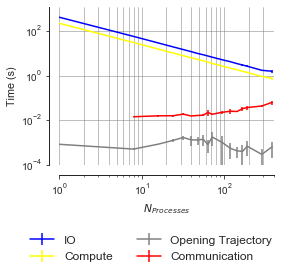

In [353]:
ax = plot_comparison(df_std_repeat, df_avg_repeat, name='time_comp_IO_comparison-no_outlier')

In [354]:
df_avg_repeat_outlier.loc[:,['t_IO','t_comp','t_init','Communication']]

,t_IO,t_comp,t_init,Communication
blocks,,,,
288,17.673447,0.909397,0.001391,0.041964


/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 288.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 288.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 288.0 results in singular transformations; automaticall

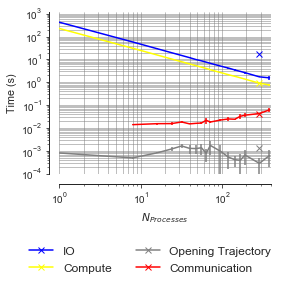

In [399]:
ax_outlier = plot_comparison(None, df_avg_repeat_outlier, name='hdf5-time_comp_IO_comparison-outlier', marker="x")
plot_comparison(df_std_repeat, df_avg_repeat, name='hdf5-time_comp_IO_comparison-combined', ax=ax_outlier)

### per rank 

In [300]:
def plot_rank(block, repeat, 
              df_comm_rank=df_comm_rank,
              df1_copy=df1_copy,
              
             ):
    """Uses lots of data frames from outside scope"""
    
    fig_name = 'BarPlot-rank-comparison_{}_{}'.format(block,repeat)
    df_comm_dist = df_comm_rank[(df_comm_rank[0]==block) & (df_comm_rank[1]==repeat)].iloc[0,2:block+2]
    df_comm_dist.index = range(2,block+2)
    df_compute_all_frame_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_comp']
    df_compute_all_frame_rank.index = range(2,block+2)
    df_IO_all_frame_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_IO']
    df_IO_all_frame_rank.index = range(2,block+2)
    df_IO_plus_comp_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_IO_plus_t_comp']
    df_IO_plus_comp_rank.index = range(2,block+2)
    df_clone_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_init']
    df_clone_rank.index = range(2,block+2)
    df_end_loop_rank = df1_copy[(df1_copy['blocks']==block) & (df1_copy['repeat']==repeat)]['t_end_loop']
    df_end_loop_rank.index = range(2,block+2)
    df_overhead1 = df_IO_plus_comp_rank.iloc[:]-df_IO_all_frame_rank.iloc[:]-df_compute_all_frame_rank.iloc[:]-df_end_loop_rank.iloc[:]
    df_overhead1.index = range(2,block+2)
    df_overhead2 = (df_comp_rank[(df_comp_rank[0]==block) & (df_comp_rank[1]==repeat)].iloc[0,2:block+2]-
                                df_IO_plus_comp_rank.iloc[:]-df_clone_rank.iloc[:])
    df_overhead2.index = range(2,block+2)

    ax = df_compute_all_frame_rank.plot(kind='bar', figsize=(6,4), color='yellow', label='Compute')
    ax = df_IO_all_frame_rank.plot(kind='bar', figsize=(6,4), color='blue', label='IO', bottom = df_compute_all_frame_rank)
    ax = df_comm_dist.plot(kind='bar', figsize=(6,4), color='red', label='Communication', bottom = 
                           [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j] for j in range(len(df_compute_all_frame_rank))])

    ax = df_overhead2.plot(kind='bar', figsize=(6,4), color='green', label='Overhead2', bottom = 
                           [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+
                            df_comm_dist.iloc[j] for j in range(len(df_compute_all_frame_rank))])

    ax = df_overhead1.plot(kind='bar', figsize=(6,4), color='black', label='Overhead1', bottom = 
                           [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j]+
                            df_overhead2.iloc[j] for j in range(len(df_compute_all_frame_rank))])

    ax = df_clone_rank.plot(kind='bar', figsize=(6,4), color='gray', label='Opening_trajectory', 
                            bottom = [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j]+
                                      df_overhead2.iloc[j]+df_overhead1.iloc[j] for j in range(len(df_compute_all_frame_rank))])

    ax = df_end_loop_rank.plot(kind='bar', figsize=(6,4), color='pink', label='Ending_loop', 
                               bottom = [df_compute_all_frame_rank.iloc[j]+df_IO_all_frame_rank.iloc[j]+df_comm_dist.iloc[j]+
                                         df_overhead2.iloc[j]+df_overhead1.iloc[j]+
                                         df_clone_rank.iloc[j] for j in range(len(df_compute_all_frame_rank))])

    ax.yaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')

    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12
    ax.set_xlabel('Processor Ranks')   
    ax.set_ylabel('Total Time (s)')
    sns.despine(offset=10, ax=ax)

    plt.tight_layout()
    plt.xticks(range(0,block,20), range(0,block,20))
    fig = ax.get_figure()
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.28),frameon=False,fancybox=True, shadow=True, ncol=3, prop={'size':12})
    plt.gcf().subplots_adjust(bottom=0.35)
    fig.savefig('{}.pdf'.format(fig_name), bbox_inches='tight')
    return fig

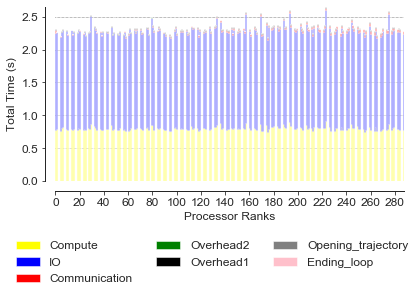

In [359]:
fig = plot_rank(288, 5, df_comm_rank=df_comm_rank, df1_copy=df1_copy)

The one run with bad outliers (N=288 cores, repeat 1):

In [360]:
fig = plot_rank(288, 1, df_comm_rank=df_comm_rank_outlier, df1_copy=df1_copy_outlier) # FAIL
# see figure from previous running of this NB

IndexError: single positional indexer is out-of-bounds

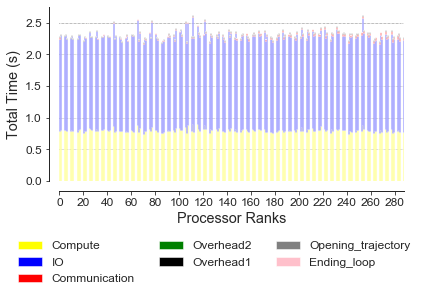

In [361]:
fig = plot_rank(288, 2, df_comm_rank=df_comm_rank, df1_copy=df1_copy)

### total time and scaling 

In [31]:
def plot_dataframe(df7, y, yerr, fig_name, ylabel, ylim, log, ax=None, **kwargs): 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 9
    if ax is None:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(1,1,1)
    else:
        fig = ax.figure
        
    kwargs.setdefault("marker", "o")
    df7.plot(y=y, x='blocks', yerr=yerr, ax=ax, lw=2, label='Comet', **kwargs)
    if (y == 'speed_up'):
        df7.plot(y='Ideal_Scaling', x='blocks', ax=ax, linestyle='--', color='k', lw=2)
    if (y == 'efficiency'):
        df7.plot(y='Ideal_Efficiency', x='blocks', ax=ax, linestyle='--', color='k', lw=2)      
        
    ax.set_xlabel('$N_{Processes}$')   
    ax.set_ylabel(ylabel)
    if log:
        ax.loglog([1, 400], [df7['t_tot_max'][0], df7['t_tot_max'][0]/400], '--', label='Ideal',color='black')
        plt.yscale('log')
        plt.xscale('log')  
        ax.set_xlim([1,405])
    else:
        ax.set_xlim([1,400])
        ax.set_ylim(ylim)    
    
    ax.yaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')
    ax.xaxis.grid(which='major',linestyle=':', linewidth='0.5', color='black')
    ax.yaxis.grid(which='minor',linestyle=':', linewidth='0.5', color='black')
    ax.xaxis.grid(which='minor',linestyle=':', linewidth='0.5', color='black') 
    ax.legend().set_visible(False)
    sns.despine(offset=10, ax=ax)
    plt.tight_layout() 
    if fig_name is not None:
        fig.savefig('{}.pdf'.format(fig_name))
    return ax

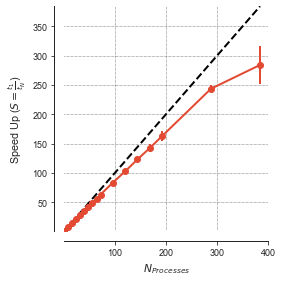

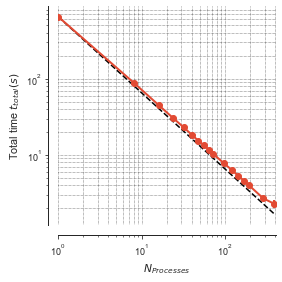

In [32]:
ax = plot_dataframe(df7, 'speed_up', 'std_S', 'hdf5-speed_up-no_outlier', r'Speed Up ($S=\frac{t_{1}}{t_{N}}$)', [1,384], False)
# plot_dataframe('efficiency', 'std_E', 'Efficiency', r'Efficiency ($\frac{S}{N}$)', [0,1.1],False)
# plot_dataframe('t_block_RMSD_mean', 'std_t_block_RMSD_mean' , 't_block_RMSD_mean', '$t_{RMSD}(s)$', [0,1050],True)
# plot_dataframe('t_comm_mean', 'std_t_comm_mean' , 't_comm_mean', '$t_{communication}(s)$', [0,1],True)
# plot_dataframe('t_block_RMSD_max', 'std_t_block_RMSD_max' , 't_block_RMSD_max', '$t_{RMSD}(s)$', [0,1050],True)
ax = plot_dataframe(df7, 't_tot_max', 'std_tot_max', 'hdf5-t_total-no_outlier', 'Total time $t_{total}(s)$', [0,1050],True)

In [384]:
df7_outlier

,blocks,repeat,P_ID,t_comp,t_IO,t_IO_plus_t_comp_mean,t_end_loop,t_init,t_IO_plus_t_comp_max,std_comp,...,std_t_comm_mean,std_t_comm_max,std_t_block_RMSD_mean,std_t_block_RMSD_max,speed_up,std_S,efficiency,std_E,Ideal_Scaling,Ideal_Efficiency
0,288,1.0,143.5,0.800807,10.0918,10.905271,9.122822e-07,0.00011,18.457859,0.027472,...,NaN,NaN,NaN,NaN,35.306965,NaN,0.122594,NaN,288,1.0


/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 288.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


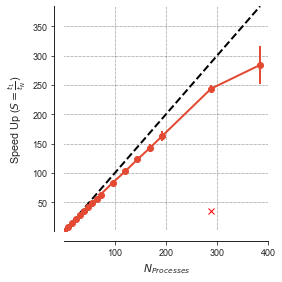

In [34]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(1,1,1)
ax1 = df7_outlier.plot(x="blocks", y='speed_up', color="r", marker="x", legend=None, ax=ax1)
ax = plot_dataframe(df7, 'speed_up', 'std_S', 'hdf5-speed_up-combined', r'Speed Up ($S=\frac{t_{1}}{t_{N}}$)', [1,384], False, 
                    legend=None, ax=ax1)
#ax.legend().set_visible(False)

/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 288.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


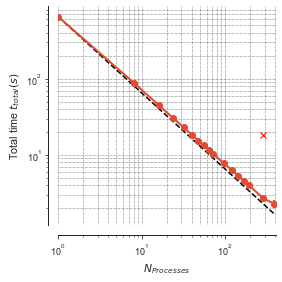

In [35]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(1,1,1)
ax1 = df7_outlier.plot(x="blocks", y='t_tot_max', color="r", marker="x", legend=None, ax=ax1)
ax = plot_dataframe(df7, 't_tot_max', 'std_tot_max', 'hdf5-t_total-combined', 'Total time $t_{total}(s)$', [0,1050],True, ax=ax1)